In [1]:
import pandas as pd
import numpy as np

from FinancialMachineLearning.machine_learning.cross_validation import *
from FinancialMachineLearning.multiprocess.multiprocess import mp_pandas_obj
from FinancialMachineLearning.features.concurrency import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/fast_ewma.py:5: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((float64[:], int64), nopython = False, nogil = True)


In [2]:
import os
os.chdir('..')
os.chdir('..')
os.getcwd()

'/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning'

In [3]:
dollar = pd.read_csv('./Data/dollar_IVEfuture.csv', index_col = 0, parse_dates = True)
dollar = dollar[~dollar.index.duplicated(keep = 'first')]
dollar

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
2009-09-28 09:46:34,80,50.79,51.070,50.7100,51.07,20044,13264,80,1.020027e+06
2009-09-28 09:52:47,142,51.07,51.148,51.0500,51.13,21024,19774,62,1.073986e+06
2009-09-28 09:54:38,201,51.14,51.150,51.1290,51.13,19951,6951,59,1.020145e+06
2009-09-28 09:55:26,243,51.13,51.150,51.1300,51.14,19652,18052,42,1.004999e+06
2009-09-28 10:02:48,339,51.14,51.260,51.0800,51.25,19943,11354,96,1.020512e+06
...,...,...,...,...,...,...,...,...,...
2023-09-14 15:54:32,10930083,162.98,163.060,162.9654,162.98,6186,3983,39,1.008408e+06
2023-09-14 15:59:20,10930131,162.99,163.040,162.9299,163.04,7158,4629,48,1.166735e+06
2023-09-14 15:59:39,10930171,163.04,163.050,162.9900,163.00,6316,3266,40,1.029639e+06


volatility

In [4]:
from FinancialMachineLearning.features.volatility import daily_volatility
vol = daily_volatility(dollar.close, lookback = 100)

CUSUM filtering

In [5]:
from FinancialMachineLearning.filter.filter import cusum_filter
cusum_events = cusum_filter(dollar.close, threshold = vol.mean())

vertical barrier

In [6]:
from FinancialMachineLearning.labeling.labeling import *
vertical_barrier = add_vertical_barrier(cusum_events, dollar['close'], num_days = 10)

Triple Barrier Methods

In [7]:
triple_barrier_events = get_events(close = dollar['close'],
                                   t_events = cusum_events[34:],
                                   pt_sl = [1, 1],
                                   target = vol,
                                   min_ret = 0.01,
                                   num_threads = 1,
                                   vertical_barrier_times = vertical_barrier,
                                   side_prediction = None)
triple_barrier_events

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/labeling/labeling.py:17: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for loc, vertical_barrier in events_['t1'].fillna(close.index[-1]).iteritems():
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(i)


,t1,trgt,pt,sl
2009-10-02 09:31:33,2009-10-02 10:35:54,0.010011,1,1
2009-10-02 09:44:59,2009-10-02 10:35:54,0.010268,1,1
2009-10-02 09:53:14,2009-10-05 09:59:08,0.010379,1,1
2009-10-02 10:01:56,2009-10-05 09:59:08,0.010430,1,1
2009-10-02 10:09:13,2009-10-05 09:59:08,0.010453,1,1
...,...,...,...,...
2023-05-08 15:16:20,2023-05-10 13:27:11,0.010701,1,1
2023-05-08 15:16:37,2023-05-12 12:21:00,0.010595,1,1
2023-05-08 15:36:39,2023-05-10 13:27:11,0.010387,1,1
2023-05-08 15:47:11,2023-05-10 13:27:11,0.010283,1,1


label concurrency

In [8]:
num_threads = 1
num_conc_events = mp_pandas_obj(concurrent_events, ('molecule', triple_barrier_events.index), num_threads, close_series_index = dollar.close.index, label_endtime = triple_barrier_events['t1'])

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/features/concurrency.py:11: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t_in, t_out in label_endtime.iteritems():
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:42: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df0 = pd.Series()
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:47: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(i)


In [9]:
num_conc_events = num_conc_events.reindex(dollar.close.index).fillna(0)

Uniqueness

In [10]:
avg_unique = mp_pandas_obj(average_uniqueness, ('molecule', triple_barrier_events.index), num_threads, 
                                 label_endtime = triple_barrier_events['t1'], num_conc_events = num_conc_events)
avg_unique

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/features/concurrency.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wght = pd.Series(index=molecule)
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/features/concurrency.py:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t_in, t_out in label_endtime.loc[wght.index].iteritems():
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:42: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df0 = pd.Series()
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:47: F

2009-10-02 09:31:33    0.275361
2009-10-02 09:44:59    0.202897
2009-10-02 09:53:14    0.134853
2009-10-02 10:01:56    0.129891
2009-10-02 10:09:13    0.126811
                         ...   
2023-05-08 15:16:20    0.020092
2023-05-08 15:16:37    0.022152
2023-05-08 15:36:39    0.020022
2023-05-08 15:47:11    0.020007
2023-05-08 15:54:13    0.020000
Length: 30053, dtype: float64

fractionally differentiated features

In [12]:
from FinancialMachineLearning.features.fracdiff import FractionalDifferentiatedFeatures
frac_dollar = FractionalDifferentiatedFeatures.fracDiff_FFD(dollar.iloc[:,4:5], 0.2)

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/features/fracdiff.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ = pd.Series()


betting side

In [13]:
labels = meta_labeling(triple_barrier_events, dollar['close'])
labels

,ret,trgt,bin
2009-10-02 09:31:33,0.011168,0.010011,1
2009-10-02 09:44:59,0.010552,0.010268,1
2009-10-02 09:53:14,0.012738,0.010379,1
2009-10-02 10:01:56,0.014995,0.010430,1
2009-10-02 10:09:13,0.013896,0.010453,1
...,...,...,...
2023-05-08 15:16:20,-0.010951,0.010701,-1
2023-05-08 15:16:37,-0.011112,0.010595,-1
2023-05-08 15:36:39,-0.010391,0.010387,-1
2023-05-08 15:47:11,-0.011105,0.010283,-1


feature matrix

In [14]:
matrix = pd.DataFrame()
matrix = pd.concat([dollar.close, labels['ret'], frac_dollar, vol, num_conc_events, avg_unique, labels['bin']], axis = 1)
matrix.columns = ['price','return','fracdiff','volatility','concurrency','uniqueness','side']
matrix = matrix.dropna()
matrix

,price,return,fracdiff,volatility,concurrency,uniqueness,side
2010-04-29 10:26:57,58.2801,-0.011465,10.476812,0.010964,20.0,0.074445,-1.0
2010-04-29 11:09:15,58.3600,-0.012819,10.507715,0.011247,7.0,0.075186,-1.0
2010-04-29 11:34:28,58.4100,-0.013664,10.488812,0.011638,5.0,0.067364,-1.0
2010-04-29 11:44:01,58.4900,-0.012306,10.540226,0.011979,6.0,0.066014,-1.0
2010-04-29 12:00:06,58.4498,-0.014335,10.465450,0.012262,7.0,0.059366,-1.0
...,...,...,...,...,...,...,...
2023-05-08 15:16:20,152.1563,-0.010951,26.030479,0.010701,46.0,0.020092,-1.0
2023-05-08 15:16:37,152.0900,-0.011112,25.963539,0.010595,47.0,0.022152,-1.0
2023-05-08 15:36:39,152.0701,-0.010391,25.952489,0.010387,48.0,0.020022,-1.0
2023-05-08 15:47:11,152.1800,-0.011105,26.065165,0.010283,49.0,0.020007,-1.0


#### Meta Labeling

In [15]:
triple_barrier_events['side'] = labels.bin
triple_barrier_events

,t1,trgt,pt,sl,side
2009-10-02 09:31:33,2009-10-02 10:35:54,0.010011,1,1,1
2009-10-02 09:44:59,2009-10-02 10:35:54,0.010268,1,1,1
2009-10-02 09:53:14,2009-10-05 09:59:08,0.010379,1,1,1
2009-10-02 10:01:56,2009-10-05 09:59:08,0.010430,1,1,1
2009-10-02 10:09:13,2009-10-05 09:59:08,0.010453,1,1,1
...,...,...,...,...,...
2023-05-08 15:16:20,2023-05-10 13:27:11,0.010701,1,1,-1
2023-05-08 15:16:37,2023-05-12 12:21:00,0.010595,1,1,-1
2023-05-08 15:36:39,2023-05-10 13:27:11,0.010387,1,1,-1
2023-05-08 15:47:11,2023-05-10 13:27:11,0.010283,1,1,-1


In [16]:
meta_labels = meta_labeling(triple_barrier_events, dollar['close'])
meta_labels

,ret,trgt,bin,side
2009-10-02 09:31:33,0.011168,0.010011,1,1
2009-10-02 09:44:59,0.010552,0.010268,1,1
2009-10-02 09:53:14,0.012738,0.010379,1,1
2009-10-02 10:01:56,0.014995,0.010430,1,1
2009-10-02 10:09:13,0.013896,0.010453,1,1
...,...,...,...,...
2023-05-08 15:16:20,0.011072,0.010701,1,-1
2023-05-08 15:16:37,0.011237,0.010595,1,-1
2023-05-08 15:36:39,0.010500,0.010387,1,-1
2023-05-08 15:47:11,0.011230,0.010283,1,-1


In [17]:
matrix['label'] = meta_labels['bin']
matrix

,price,return,fracdiff,volatility,concurrency,uniqueness,side,label
2010-04-29 10:26:57,58.2801,-0.011465,10.476812,0.010964,20.0,0.074445,-1.0,1
2010-04-29 11:09:15,58.3600,-0.012819,10.507715,0.011247,7.0,0.075186,-1.0,1
2010-04-29 11:34:28,58.4100,-0.013664,10.488812,0.011638,5.0,0.067364,-1.0,1
2010-04-29 11:44:01,58.4900,-0.012306,10.540226,0.011979,6.0,0.066014,-1.0,1
2010-04-29 12:00:06,58.4498,-0.014335,10.465450,0.012262,7.0,0.059366,-1.0,1
...,...,...,...,...,...,...,...,...
2023-05-08 15:16:20,152.1563,-0.010951,26.030479,0.010701,46.0,0.020092,-1.0,1
2023-05-08 15:16:37,152.0900,-0.011112,25.963539,0.010595,47.0,0.022152,-1.0,1
2023-05-08 15:36:39,152.0701,-0.010391,25.952489,0.010387,48.0,0.020022,-1.0,1
2023-05-08 15:47:11,152.1800,-0.011105,26.065165,0.010283,49.0,0.020007,-1.0,1


In [38]:
X = matrix.iloc[:,[0,2,3,4]]
y = matrix.iloc[:,-1]
weights= matrix.iloc[:, 5]

#idx_shuffle = np.random.permutation(X.index)

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

#### sklearn K Fold Validation

In [40]:
clf = RandomForestClassifier(n_estimators = 1000,
                            criterion = 'entropy', 
                            random_state = 42,
                            class_weight = 'balanced_subsample', 
                            ccp_alpha = 0.001,
                            min_weight_fraction_leaf = 0.05,
                            max_samples = matrix['uniqueness'].mean(),
                            max_features = 20)

cv_gen = KFold(n_splits = 10)

scores = ml_cross_val_score(clf, X_train, y_train, cv_gen, scoring = accuracy_score, sample_weight = weights)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.22)


#### Purged K Fold

In [31]:
samples_info_sets = triple_barrier_events['t1'][:20590]

In [41]:
cv_gen = PurgedKFold(n_splits=10, samples_info_sets = samples_info_sets, pct_embargo = 0.01)
scores = ml_cross_val_score(clf, X_train, y_train, cv_gen, scoring = accuracy_score, sample_weight = weights)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in test_times.iteritems():
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in test_times.iteritems():
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in test_times.iteritems():
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be

[0.97820636 0.96682242 0.94194711 0.90650341 0.947473   0.93614252
 0.55228534 0.90647779 0.95396941 0.94270866]
Accuracy: 0.90 (+/- 0.24)


In [42]:
model = clf.fit(X_train, y_train)

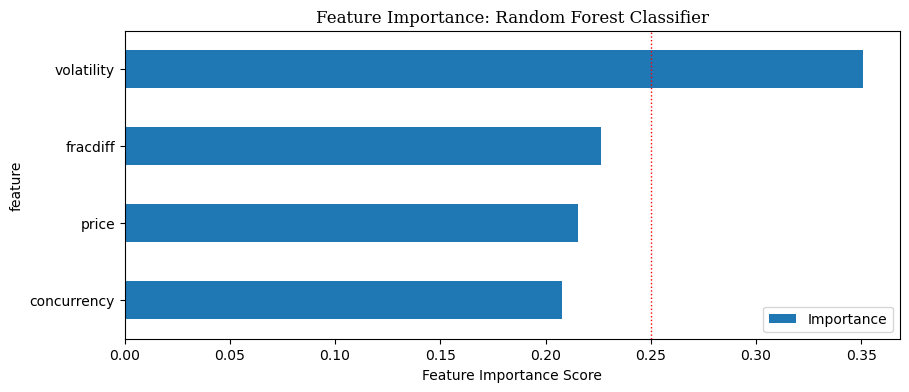

In [43]:
import matplotlib.pyplot as plt
title = 'Feature Importance: Random Forest Classifier'
figsize = (10, 4)

feat_imp = pd.DataFrame({'Importance':clf.feature_importances_})
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending = False, inplace = True)
feat_imp = feat_imp

feat_imp.sort_values(by = 'Importance', inplace = True)
feat_imp = feat_imp.set_index('feature', drop = True)
feat_imp.plot.barh(figsize = figsize)
plt.axvline(1. / feat_imp.shape[0], linewidth = 1, color='r', linestyle='dotted')
plt.xlabel('Feature Importance Score')
plt.title(title, fontsize = 12, fontfamily = 'Serif')
plt.show()

              precision    recall  f1-score   support

    no trade       0.81      0.04      0.07       573
       trade       0.94      1.00      0.97      8252

    accuracy                           0.94      8825
   macro avg       0.87      0.52      0.52      8825
weighted avg       0.93      0.94      0.91      8825


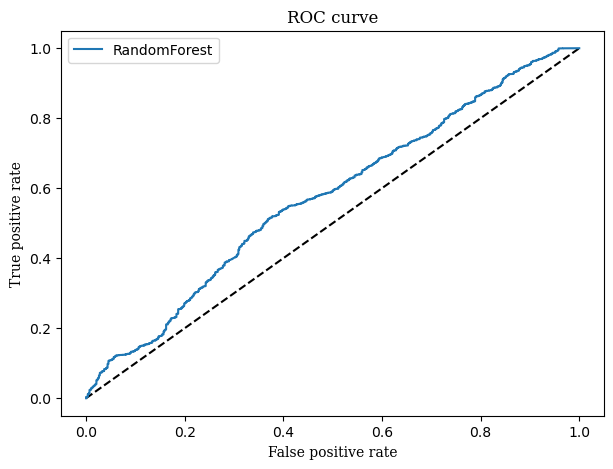

In [44]:
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
y_pred_rf = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr_bc, tpr_bc, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (7,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc, tpr_bc, label = 'RandomForest')
plt.grid(False)
plt.xlabel('False positive rate', fontfamily = 'Serif')
plt.ylabel('True positive rate', fontfamily = 'Serif')
plt.title('ROC curve', fontsize = 12, fontfamily = 'Serif')
plt.legend(loc = 'best')
plt.show()

#### Back testing

In [53]:
backtest = pd.DataFrame()
backtest['Predict'] = model.predict(X_test)
backtest['Actual'] = y_test.values
backtest['Betting Size'] = model.predict_proba(X_test)[:,1]
backtest['Return'] = np.log(matrix.price / matrix.price.shift(1))[-8825:].values
backtest['side'] = matrix['side'][-8825:].values
backtest['Backtest'] = model.predict_proba(X_test)[:,1] * backtest['Return'].values
backtest.index = X_test.index
backtest

,Predict,Actual,Betting Size,Return,side,Backtest
2020-09-03 13:30:00,1,1,0.650608,0.002239,-1.0,0.001457
2020-09-03 13:33:51,1,1,0.646922,-0.003274,-1.0,-0.002118
2020-09-03 13:39:20,1,1,0.640733,-0.000777,-1.0,-0.000498
2020-09-03 13:45:09,1,1,0.640053,0.000950,-1.0,0.000608
2020-09-03 13:52:55,1,1,0.641363,0.000173,-1.0,0.000111
...,...,...,...,...,...,...
2023-05-08 15:16:20,1,1,0.621138,-0.000340,-1.0,-0.000211
2023-05-08 15:16:37,1,1,0.632743,-0.000436,-1.0,-0.000276
2023-05-08 15:36:39,1,1,0.634443,-0.000131,-1.0,-0.000083
2023-05-08 15:47:11,1,1,0.628396,0.000722,-1.0,0.000454


Text(0.5, 1.0, 'Becktesting Machine Learning Model')

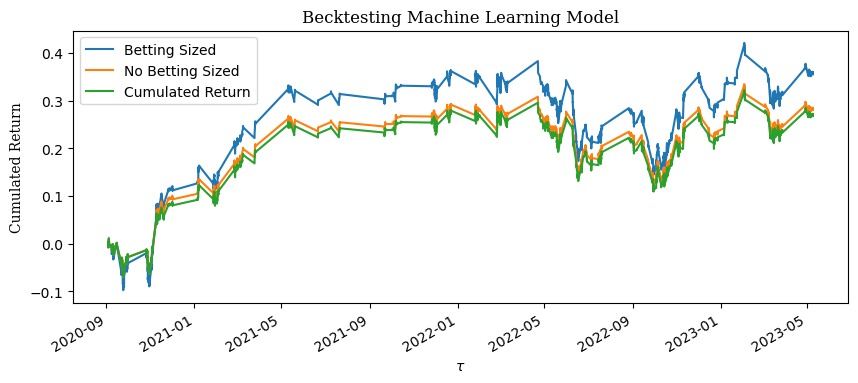

In [54]:
plt.figure(figsize = (10,4))
(backtest[backtest['Predict'] == 1]['Backtest']*2).cumsum().plot(label = 'Betting Sized')
backtest[backtest['Predict'] == 1]['Return'].cumsum().plot(label = 'No Betting Sized')
backtest['Return'].cumsum().plot(label = 'Cumulated Return')
plt.legend()
plt.grid(False)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Cumulated Return', fontfamily = 'Serif')
plt.title('Becktesting Machine Learning Model', fontsize = 12, fontfamily = 'Serif')